In [2]:
# import tensorflow_datasets as tfds 
import tensorflow as tf 
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt 

In [3]:
partial_train_paths = ["1.2.826.0.1.3680043.8.498.10512646429067653616115199126403653207.jpg",
                      "1.2.826.0.1.3680043.8.498.10553203729695529217457522953701922196.jpg",
                      "1.2.826.0.1.3680043.8.498.10600230317881874653883891692747043009.jpg",
                      "1.2.826.0.1.3680043.8.498.10624933077182432060278847366271157598.jpg",
                      "1.2.826.0.1.3680043.8.498.11622806412637082718421427225521519105.jpg",
                      "1.2.826.0.1.3680043.8.498.22722315540436745494925507742445314611.jpg",
                      "1.2.826.0.1.3680043.8.498.24659262645697474332452835516529431375.jpg",
                      "1.2.826.0.1.3680043.8.498.25104812635631369211532685559484916373.jpg",
                      "1.2.826.0.1.3680043.8.498.26125446155146594477818772749289794656.jpg",
                      "1.2.826.0.1.3680043.8.498.30175383221630293697688953326853182323.jpg",
                      "1.2.826.0.1.3680043.8.498.39765309636918130294613488440061655672.jpg",
                      "1.2.826.0.1.3680043.8.498.46964849257665456312075806312231735913.jpg",
                      "1.2.826.0.1.3680043.8.498.55922793951803274282980287168731264210.jpg",
                      "1.2.826.0.1.3680043.8.498.59008169249054242133470997981950698585.jpg",
                      "1.2.826.0.1.3680043.8.498.74067092954277858591731369789552043856.jpg",
                      "1.2.826.0.1.3680043.8.498.98113606368909263623427693214007380286.jpg"]
train_paths = [f"data/partial_train/" + path for path in partial_train_paths]

labels = [0]*8 + [1]*8 

In [4]:
AUTO = tf.data.experimental.AUTOTUNE #最大並列計算数?, ただの-1?

In [5]:
def create_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1,activation="sigmoid")
    ])
    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4),
                  loss = tf.keras.losses.BinaryCrossentropy(),
                  metrics = [tf.keras.metrics.AUC()])
    return model

## How to load data

In [6]:
train_dset = tf.data.Dataset.from_tensor_slices((train_paths,labels))
test_dset = tf.data.Dataset.from_tensor_slices(train_paths)
print(train_dset)
print(test_dset)

<TensorSliceDataset shapes: ((), ()), types: (tf.string, tf.int32)>
<TensorSliceDataset shapes: (), types: tf.string>


## How to decode images

In [7]:
def decoder(img_path):
    file_byte = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(file_byte,channels=3)
    img = tf.cast(img,tf.float32) #float32にcast
    img /= 255.0
    img = tf.image.resize(img,[256,256])
    return img 

def decoder_with_label(img_path,label):
    return decoder(img_path),label

In [8]:
train_data = train_dset.map(decoder_with_label,num_parallel_calls=AUTO)
test_data = test_dset.map(decoder,num_parallel_calls=AUTO)
print(train_data)
print(test_data)

<ParallelMapDataset shapes: ((256, 256, 3), ()), types: (tf.float32, tf.int32)>
<ParallelMapDataset shapes: (256, 256, 3), types: tf.float32>


## How  to show images

In [11]:
def show_image(train_data,n):
    #:param dset: decodeされたtf.dataset
    #:param n <= 16: dsetの初めからn個の画像を表示する
    col = (n + 3 - 1)//3 
    fig,axes = plt.subplots(col,3,figsize=(7*3,7*col))
    axes = axes.ravel()
    for i,(img,label) in enumerate(train_data.take(n)):
        axes[i].imshow(img)
        axes[i].set_title(f"No.{i} image")
        axes[i].set_xticks([])
        axes[i].set_yticks([])
    axes.reshape(col,3)
    plt.tight_layout()
    plt.show()

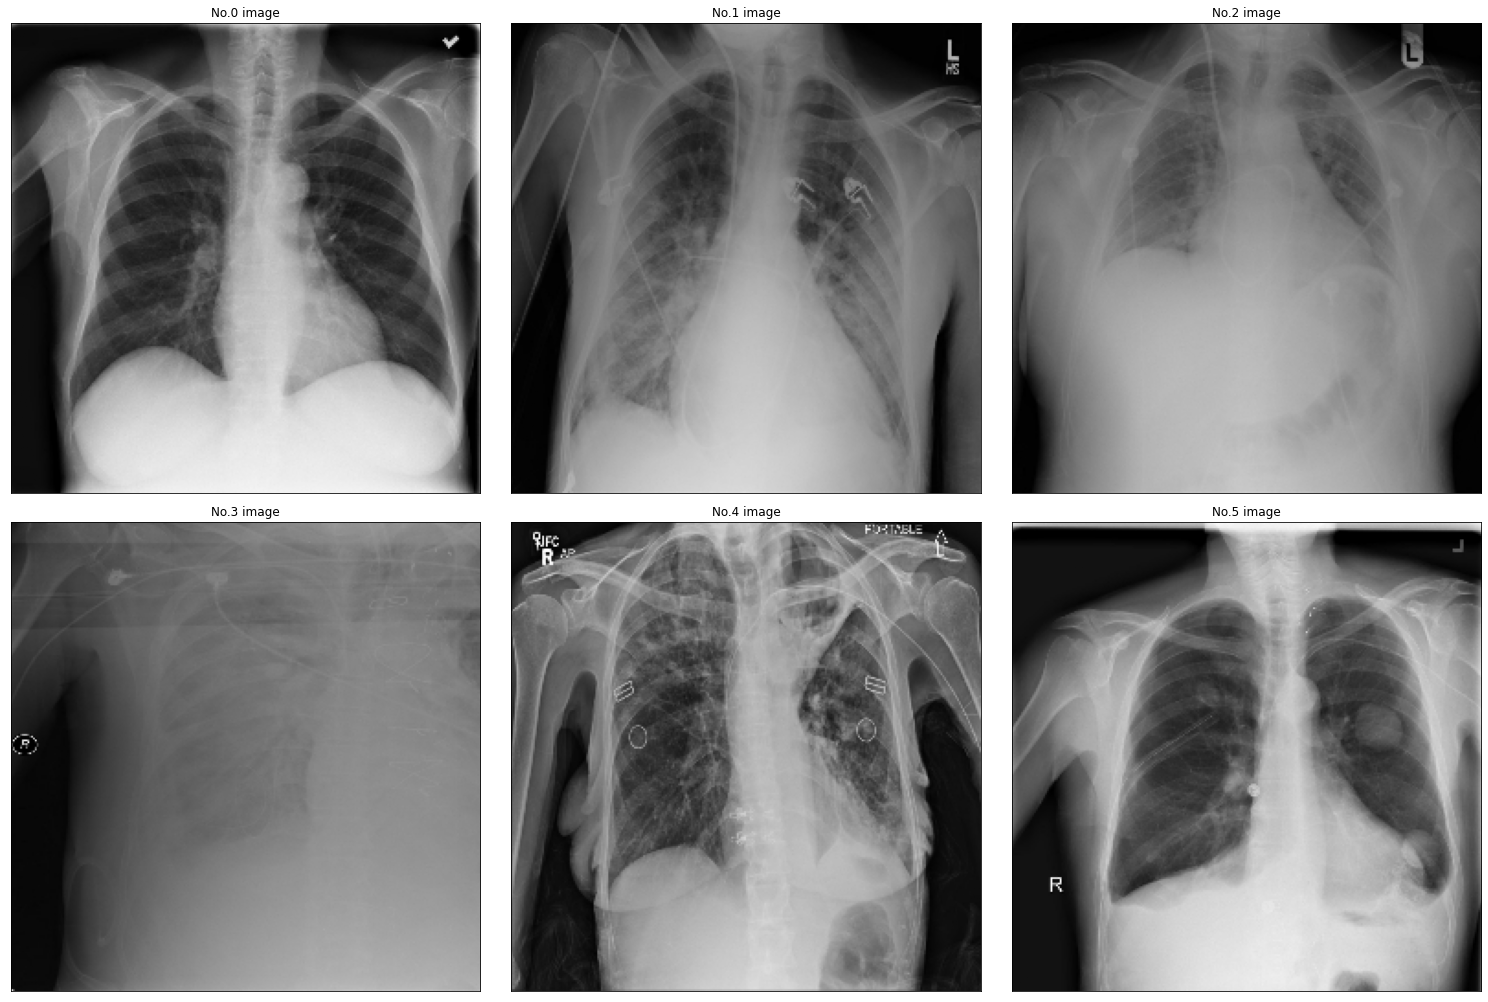

In [12]:
show_image(train_data,6)

## How to train 

In [10]:
#train
train_data = train_data.repeat(count=2) #デフォルトではcount = None(repeated indefinetely)
train_data = train_data.shuffle(buffer_size=4) #画像をシャッフルする, buffer_sizeはメモリにのるandデータサイズ以下で範囲でできるだけ大きくするとよい
train_data = train_data.batch(2)
train_data = train_data.prefetch(AUTO)

#test
test_data = test_data.batch(2)
test_data = test_data.prefetch(AUTO)

In [ ]:
model = create_model()
history = model.fit(train_data,
                    epochs=1)
#kernel dead 

## More 
- How to augment data <br> 
- How to cache data for speeding up training<br>